In [1]:
!pip install tensorflow==2.11 keras==2.11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninst

In [2]:
!pip install pennylane==0.34.0

INFO: pip is looking at multiple versions of pennylane-lightning to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf


# Get the MNIST Data
mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(len(x_train), len(y_test))

labels = {0 : "T-shirt/top",
          1	: "Trouser",
          2	: "Pullover",
          3	: "Dress",
          4	: "Coat",
          5	: "Sandal",
          6	: "Shirt",
          7	: "Sneaker",
          8	: "Bag",
          9	: "Ankle boot"}


4422102/4422102 [==============================] - 0s 0us/step
60000 10000


In [4]:
n_qubits = 6                  # Number of qubits
num_layers = 1                # Number of layers

is_data_reduced = True        # Data is reduced to n classes
reduced_classes = [1,2,3,7]   # Selected (and sorted) classes

reduced_labels = [labels[v] for v in reduced_classes]

# Number of reduced classes
reduced_num_classes = len(reduced_classes)

reduce_scale = 2

if reduce_scale:
  x_train = x_train[:int(len(x_train)/reduce_scale)]
  y_train = y_train[:int(len(y_train)/reduce_scale)]

  x_test = x_test[:int(len(x_test)/reduce_scale)]
  y_test = y_test[:int(len(y_test)/reduce_scale)]

In [5]:
# All indexes
train_index_f = (y_train == -1)
tests_index_f = (y_test  == -1)

if is_data_reduced:
  # Filter indexes
  for n_class in reduced_classes:
    train_index_f   |= (y_train == n_class) 
    tests_index_f   |= (y_test == n_class)

  num_classes_q = reduced_num_classes

# New databases
X_ends_pre = x_train[train_index_f]
Y_ends_pre = y_train[train_index_f]

X_tests_pre = x_test[tests_index_f]
Y_tests_pre = y_test[tests_index_f]


if is_data_reduced:
  # Change categories to their new range.
  # E.g. {0,...,9} -> {0,...,4}
  for i, k in enumerate(reduced_classes):
    Y_ends_pre[Y_ends_pre == k] = i
    Y_tests_pre[Y_tests_pre == k] = i

In [6]:
# All indexes
train_index_f = (y_train == -1)
tests_index_f = (y_test  == -1)

if is_data_reduced:
  # Filter indexes
  for n_class in reduced_classes:
    train_index_f   |= (y_train == n_class) 
    tests_index_f   |= (y_test == n_class)

  num_classes_q = reduced_num_classes

# New databases
X_ends_pre = x_train[train_index_f]
Y_ends_pre = y_train[train_index_f]

X_tests_pre = x_test[tests_index_f]
Y_tests_pre = y_test[tests_index_f]


if is_data_reduced:
  # Change categories to their new range.
  # E.g. {0,...,9} -> {0,...,4}
  for i, k in enumerate(reduced_classes):
    Y_ends_pre[Y_ends_pre == k] = i
    Y_tests_pre[Y_tests_pre == k] = i

In [7]:
latent_dim = 2 ** n_qubits    # Selected latent dimensions

class Autoencoder(tf.keras.models.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(name = "faltten_1"),
      tf.keras.layers.Dense(196, activation='relu', name = "dense_1"),
      tf.keras.layers.Dense(64, activation='relu', name = "dense_2"),
      tf.keras.layers.Dense(latent_dim, activation='relu', name = "dense_3"),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu', name = "dense_4"),
      tf.keras.layers.Dense(196, activation='relu', name = "dense_5"),
      tf.keras.layers.Dense(784, activation='sigmoid', name = "dense_6"),
      tf.keras.layers.Reshape((28, 28), name = "reshape_1")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Prepare and compile the model
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='mae', metrics=["accuracy"])

# Train the model with the filtered data
autoencoder.fit(X_ends_pre, X_ends_pre, epochs=100, shuffle=True, validation_data=(X_tests_pre, X_tests_pre))


Epoch 1/100
377/377 [==============================] - 3s 5ms/step - loss: 0.1137 - accuracy: 0.1058 - val_loss: 0.0796 - val_accuracy: 0.1293
Epoch 2/100
377/377 [==============================] - 2s 4ms/step - loss: 0.0712 - accuracy: 0.1420 - val_loss: 0.0654 - val_accuracy: 0.1561
Epoch 3/100
377/377 [==============================] - 2s 4ms/step - loss: 0.0625 - accuracy: 0.1633 - val_loss: 0.0604 - val_accuracy: 0.1735
Epoch 4/100
377/377 [==============================] - 2s 4ms/step - loss: 0.0581 - accuracy: 0.1811 - val_loss: 0.0576 - val_accuracy: 0.1856
Epoch 5/100
377/377 [==============================] - 2s 5ms/step - loss: 0.0553 - accuracy: 0.1927 - val_loss: 0.0556 - val_accuracy: 0.1946
Epoch 6/100
377/377 [==============================] - 2s 5ms/step - loss: 0.0534 - accuracy: 0.2020 - val_loss: 0.0542 - val_accuracy: 0.2035
Epoch 7/100
377/377 [==============================] - 2s 4ms/step - loss: 0.0519 - accuracy: 0.2072 - val_loss: 0.0520 - val_accuracy: 0.2204

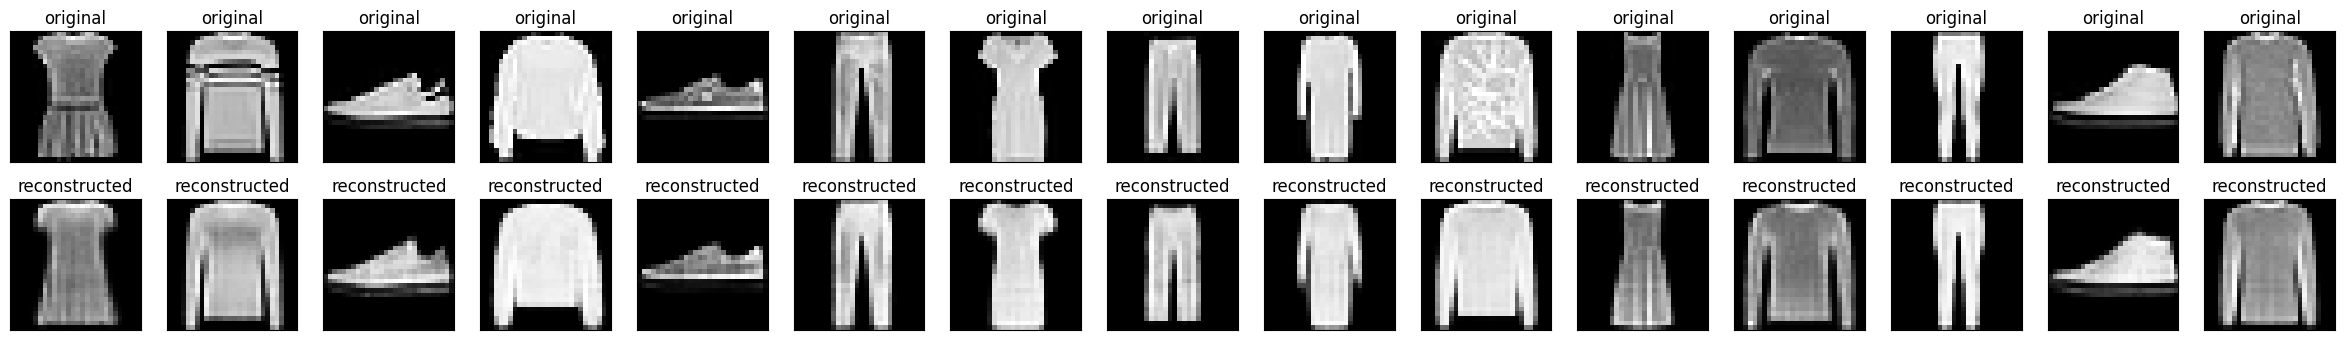

In [8]:
import matplotlib.pyplot as plt

encoded_imgs = autoencoder.encoder(X_ends_pre).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 15
plt.figure(figsize=(30, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_ends_pre[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
# Encode data with our new autoencoder
QX_train = autoencoder.encoder(X_ends_pre).numpy()
QX_test = autoencoder.encoder(X_tests_pre).numpy()

# Change Y values to categorical
QY_train = tf.keras.utils.to_categorical(Y_ends_pre, num_classes_q)
QY_test = tf.keras.utils.to_categorical(Y_tests_pre, num_classes_q)

In [10]:
import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers

In [11]:
dev = qml.device("default.qubit", wires = n_qubits)

@qml.qnode(dev, diff_method='adjoint')
def circuit(weights, inputs=None):
  ''' Quantum QVC Circuit'''

  # Splits need to be done through the tensorflow interface
  weights_each_layer = tf.split(weights, num_or_size_splits=num_layers, axis=0)
  
  # Input normalization
  inputs_1 = inputs / p_np.sqrt(max(p_np.sum(inputs ** 2, axis=-1), 0.001))

  for i, W in enumerate(weights):
    # Data re-uploading technique
    if i % 2 == 0:
      MottonenStatePreparation(inputs_1, wires = range(n_qubits))
    
    # Neural network layer
    StronglyEntanglingLayers(weights_each_layer[i], wires=range(n_qubits))
  
  # Measurement return
  return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] 

In [12]:
weight_shapes = {"weights": (num_layers,n_qubits,3)}

# Model  
input_m = tf.keras.layers.Input(shape=(2 ** n_qubits,), name = "input_0")
keras_1 = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=n_qubits, name = "keras_1")(input_m)
output = tf.keras.layers.Dense(num_classes_q, activation='softmax', name = "dense_1")(keras_1)

# Model creation
model = tf.keras.Model(inputs=input_m, outputs=output, name="mnist_quantum_model")

# Model compilation
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) ,
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

# Example data (Replace with your actual data)
# Assuming original data has 64 features
QX_train = np.random.rand(128448, 64)  # Original QX_train with 64 features
QY_train = np.random.rand(12042, 4)
QX_test = np.random.rand(2002, 64)
QY_test = np.random.rand(2002, 4)

# Display original shapes
print(f"Original QX_train shape: {QX_train.shape}")  # (128448, 64)
print(f"Original QY_train shape: {QY_train.shape}")  # (12042, 4)
print(f"Original QX_test shape: {QX_test.shape}")    # (2002, 64)
print(f"Original QY_test shape: {QY_test.shape}")    # (2002, 4)

# Strategy A: Truncate QX_train and QY_train to the minimum number of samples
min_samples = min(QX_train.shape[0], QY_train.shape[0])

QX_train_matched = QX_train[:min_samples]
QY_train_matched = QY_train[:min_samples]

print(f"Truncated QX_train shape: {QX_train_matched.shape}")  # (12042, 64)
print(f"Truncated QY_train shape: {QY_train_matched.shape}")  # (12042, 4)

# Strategy B: Aggregate QX_train if multiple samples correspond to one QY_train sample
ratio = QX_train.shape[0] // QY_train.shape[0]  # Approximately 10.67

if ratio >= 10:
    ratio = 10
    new_size = ratio * QY_train.shape[0]
    QX_train_trimmed = QX_train[:new_size]
    QX_train_aggregated = QX_train_trimmed.reshape(QY_train.shape[0], ratio, QX_train.shape[1]).mean(axis=1)

    print(f"Aggregated QX_train shape: {QX_train_aggregated.shape}")  # (12042, 64)

    # Now, QX_train_matched and QY_train_matched are aligned
    QX_train_matched = QX_train_aggregated
    QY_train_matched = QY_train[:QX_train_aggregated.shape[0]]
else:
    print("Aggregation not performed due to unsuitable ratio.")

# Final matched shapes
print(f"Final QX_train_matched shape: {QX_train_matched.shape}")  # (12042, 64)
print(f"Final QY_train_matched shape: {QY_train_matched.shape}")  # (12042, 4)

# Step 1: Select the same 6 features from QX_train_matched
# For example, selecting the first 6 features. Adjust the indices as needed.
selected_feature_indices = [0, 1, 2, 3, 4, 5]  # Indices of the 6 features to select

QX_train_selected = QX_train_matched[:, selected_feature_indices]
print(f"QX_train_selected shape: {QX_train_selected.shape}")  # (12042, 6)

# Step 2: Apply the same scaling
scaler = StandardScaler()
QX_train_scaled = scaler.fit_transform(QX_train_selected)
print(f"QX_train_scaled shape: {QX_train_scaled.shape}")  # (12042, 6)

# Select the same 6 features from QX_test
QX_test_selected = QX_test[:, selected_feature_indices]
print(f"QX_test_selected shape: {QX_test_selected.shape}")  # (2002, 6)

# Apply scaling to QX_test_selected
QX_test_scaled = scaler.transform(QX_test_selected)
print(f"QX_test_scaled shape: {QX_test_scaled.shape}")      # (2002, 6)

# Define your model (example)
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(6,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(4)  # Assuming regression; adjust activation if classification
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Original QX_train shape: (128448, 64)
Original QY_train shape: (12042, 4)
Original QX_test shape: (2002, 64)
Original QY_test shape: (2002, 4)
Truncated QX_train shape: (12042, 64)
Truncated QY_train shape: (12042, 4)
Aggregated QX_train shape: (12042, 64)
Final QX_train_matched shape: (12042, 64)
Final QY_train_matched shape: (12042, 4)
QX_train_selected shape: (12042, 6)
QX_train_scaled shape: (12042, 6)
QX_test_selected shape: (2002, 6)
QX_test_scaled shape: (2002, 6)


In [14]:
# Fit the model
model.fit(QX_train_scaled, QY_train_matched, epochs=10, batch_size=8, shuffle=True)

Epoch 1/10
1506/1506 [==============================] - 3s 1ms/step - loss: 0.0930 - mae: 0.2592
Epoch 2/10
1506/1506 [==============================] - 2s 2ms/step - loss: 0.0851 - mae: 0.2515
Epoch 3/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0844 - mae: 0.2508
Epoch 4/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0840 - mae: 0.2502
Epoch 5/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0837 - mae: 0.2498
Epoch 6/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0836 - mae: 0.2497
Epoch 7/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0835 - mae: 0.2496
Epoch 8/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0833 - mae: 0.2494
Epoch 9/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0833 - mae: 0.2493
Epoch 10/10
1506/1506 [==============================] - 2s 1ms/step - loss: 0.0832 - mae: 0.2492


In [15]:
# Evaluate the model
results = model.evaluate(QX_test_scaled, QY_test)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

63/63 [==============================] - 0s 1ms/step - loss: 0.0961 - mae: 0.2640
Test Loss: 0.09614070504903793, Test MAE: 0.2639884650707245


1/1 [==============================] - 0s 88ms/step


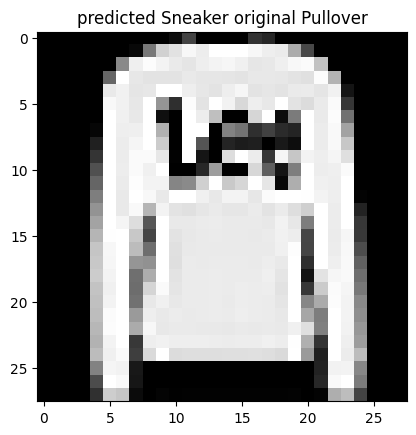

1/1 [==============================] - 0s 18ms/step


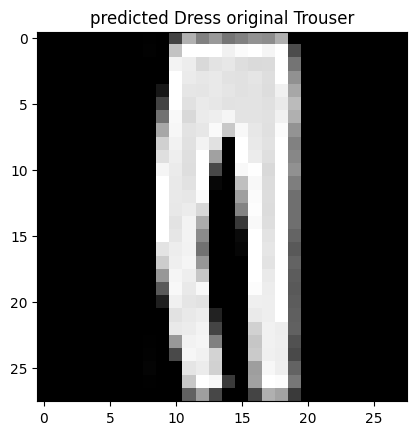

1/1 [==============================] - 0s 17ms/step


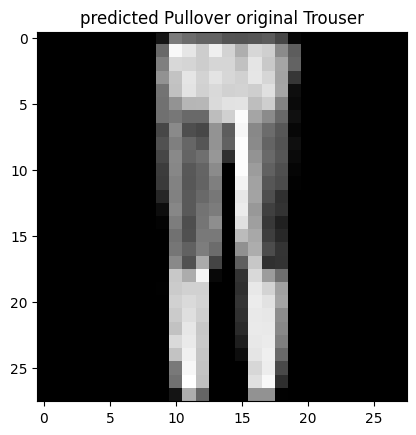

In [16]:
for i in range(0, 3):
    predicted= np.argmax(model.predict(QX_test_scaled[i:i+1]))
    plt.imshow(X_tests_pre[i])
    plt.title(f"predicted {reduced_labels[predicted]} original {reduced_labels[Y_tests_pre[i]]}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [17]:
predicted = model.predict(QX_test_scaled)

63/63 [==============================] - 0s 1ms/step


In [18]:
from collections import Counter
predicted_argmax = np.argmax(predicted, axis=1)
incorrect = predicted_argmax != Y_tests_pre
print(Counter(Y_tests_pre[incorrect]))

Counter({2: 428, 0: 399, 1: 385, 3: 319})


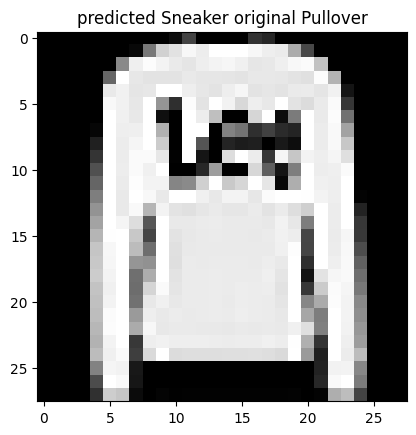

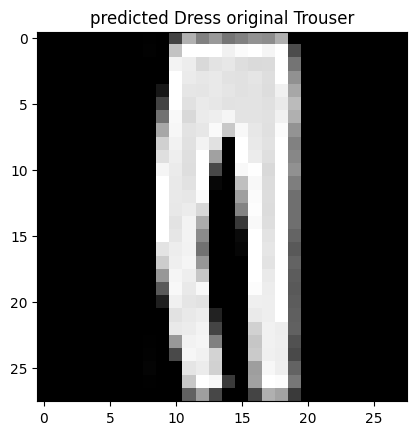

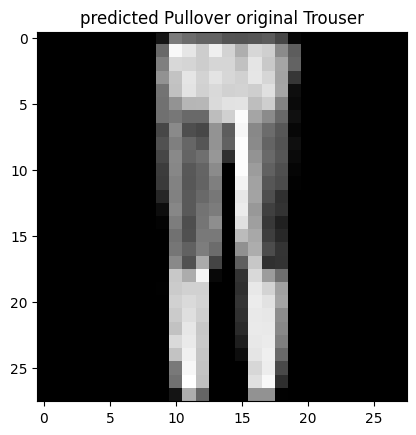

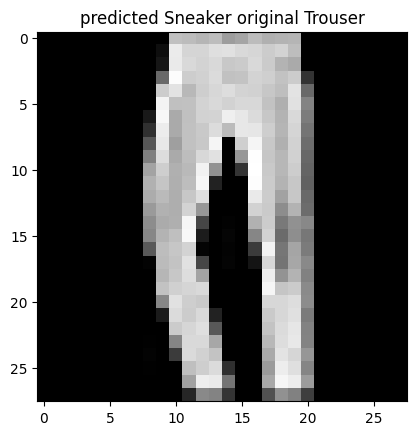

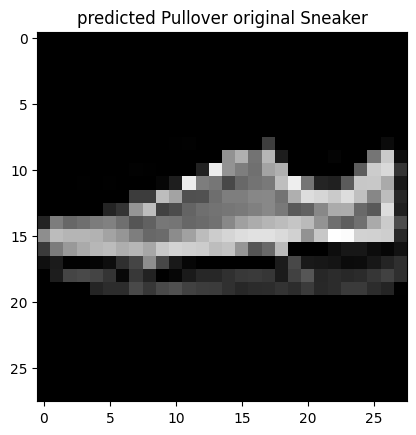

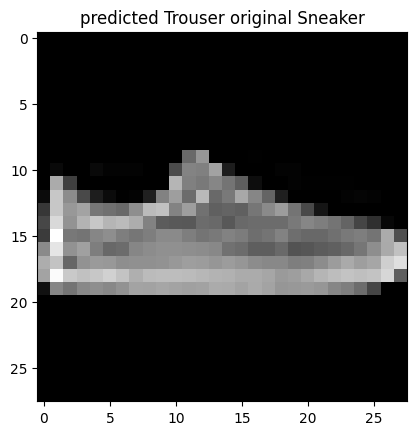

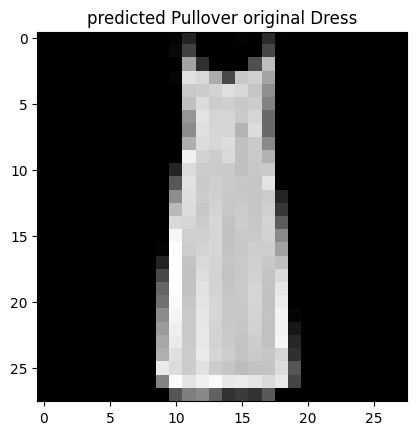

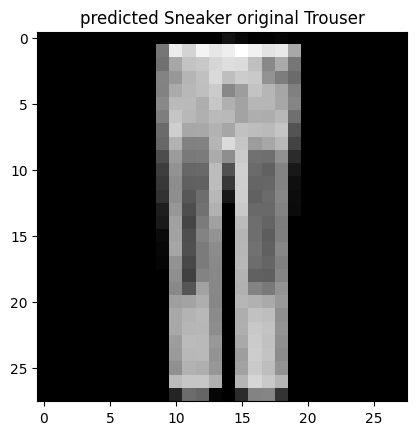

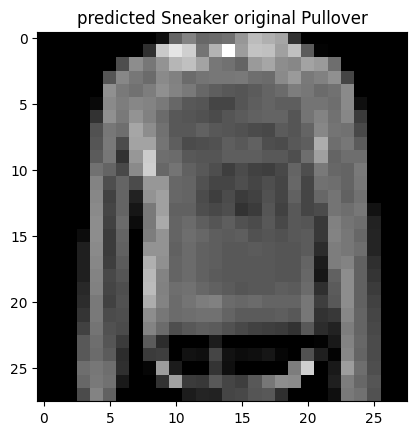

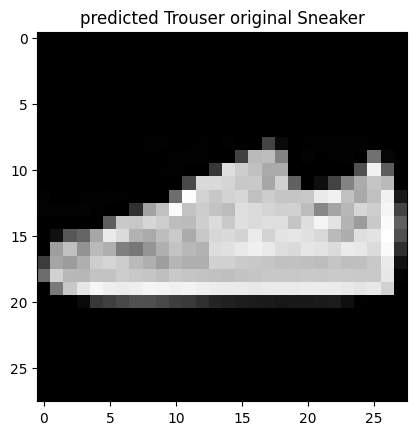

In [19]:
count = 10
x_t = X_tests_pre[incorrect][:count]
y_t = Y_tests_pre[incorrect][:count]
p_t = predicted_argmax[incorrect][:count]

for x,y,p in zip(x_t, y_t, p_t):
    plt.imshow(x)
    plt.title(f"predicted {reduced_labels[p]} original {reduced_labels[y]}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
